1번

In [17]:
from IPython.display import Image

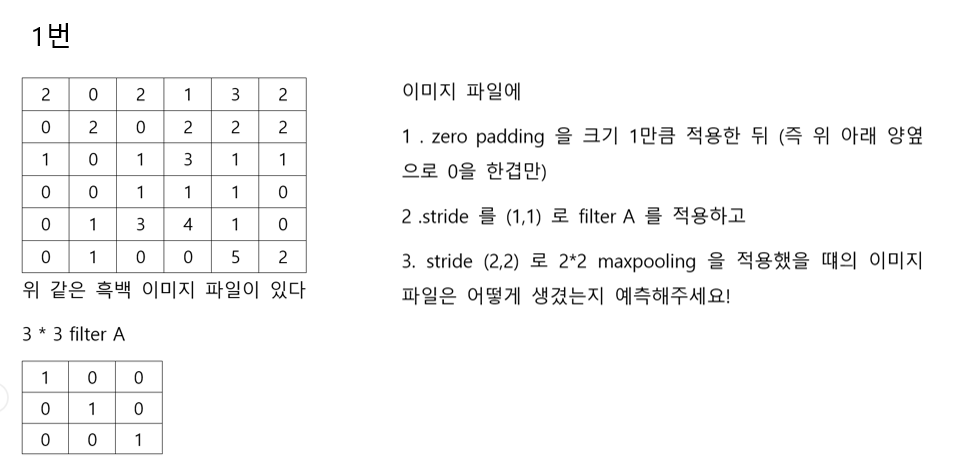

In [18]:
Image("C:/Users/goran/Desktop/esc/1번.png") 

In [2]:
zero_padding=[[0,0,0,0,0,0,0,0],
              [0,2,0,2,1,3,2,0],
              [0,0,2,0,2,2,2,0],
              [0,1,0,1,3,1,1,0],
              [0,0,0,1,1,1,0,0],
              [0,0,1,3,4,1,0,0],
              [0,0,1,0,0,5,2,0],
              [0,0,0,0,0,0,0,0]]

In [3]:
after_filter=[[4,0,4,3,5,2],
              [0,5,3,5,4,5],
              [1,1,4,4,3,3],
              [1,4,5,3,4,1],
              [1,1,3,10,4,1],
              [0,1,1,3,9,3]]

In [4]:
answer=[[2,2,3,2],
        [1,2,3,2],
        [0,3,4,0],
        [0,1,5,2]]

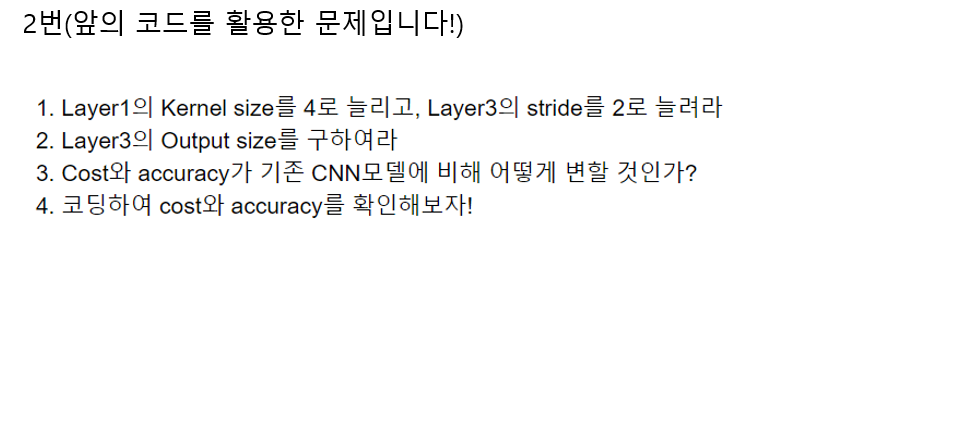

In [19]:
Image("C:/Users/goran/Desktop/esc/2번.png") 

## 정답

- Layer 1
    <br>
    Convolution Layer:(in_c=1, out_c=32, kernel_size=4, stride=1, padding=1)
    <br>
    MaxPool Layer: (kernel_size=2, stride=2)
    <br>
    <br>
- Layer 2
    <br>
    Convolution Layer:(in_c=32, out_c=64, kernel_size=3, stride=1, padding=1)
    <br>
    MaxPool Layer: (kernel_size=2, stride=2)
    <br>
    <br>
- **Layer 3**
    <br>
    Convolution Layer:(in_c=64, out_c=128, kernel_size=3, stride=2, padding=1)
    <br>
    MaxPool Layer: (kernel_size=2, stride=2)
    <br>
    <br>

- view
    <br>
    batch_size x [1,1,128] $\Rightarrow$ batch_size x[128]
    <br>
    <br>

- **Layer 4**
    <br>
    Fully Connected Layer:(in_c=1*1*128, out_c=625)
    <br>
    <br>
    
- **Layer 5**
    <br>
    Fully Connected Layer:(in_c=625, out_c=10)

In [6]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.nn.init
import torch.nn as nn

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# for reproducibility
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

In [8]:
# parameters
learning_rate = 0.001
training_epochs = 15
batch_size = 100

In [9]:
#MNIST dataset
mnist_train = dsets.MNIST(root='MNIST_data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

mnist_test = dsets.MNIST(root='MNIST_data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

100.1%

Extracting MNIST_data/MNIST\raw\train-images-idx3-ubyte.gz to MNIST_data/MNIST\raw


113.5%

Extracting MNIST_data/MNIST\raw\train-labels-idx1-ubyte.gz to MNIST_data/MNIST\raw


100.4%

Extracting MNIST_data/MNIST\raw\t10k-images-idx3-ubyte.gz to MNIST_data/MNIST\raw


180.4%

Extracting MNIST_data/MNIST\raw\t10k-labels-idx1-ubyte.gz to MNIST_data/MNIST\raw
Processing...
Done!


C:\Users\goran\Anaconda3\envs\torch\lib\site-packages\torchvision\datasets\mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [10]:
# dataset loader
data_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          drop_last=True)

In [30]:
class CNN(torch.nn.Module):
    
    def __init__(self):
        
        super(CNN,self).__init__()
        self.keep_prob = 0.5
        
        self.layer1 = torch.nn.Sequential(torch.nn.Conv2d(1,32,kernel_size=4, stride=1, padding=1),
                                         torch.nn.ReLU(), torch.nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer2 = torch.nn.Sequential(torch.nn.Conv2d(32,64,kernel_size=3, stride=1, padding=1),
                                         torch.nn.ReLU(), torch.nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer3 = torch.nn.Sequential(torch.nn.Conv2d(64,128, kernel_size=3, stride=2, padding=1),
                                         torch.nn.ReLU(), torch.nn.MaxPool2d(kernel_size=2,stride=2, padding=1))
        
        self.fc1 = torch.nn.Linear(2*2*128,625, bias=True)
        torch.nn.init.xavier_uniform_(self.fc1.weight)
        self.layer4 = torch.nn.Sequential(self.fc1, torch.nn.ReLU(), torch.nn.Dropout(p=1-self.keep_prob))
        
        self.fc2 = torch.nn.Linear(625, 10, bias =True)
        torch.nn.init.xavier_uniform_(self.fc2.weight)
        
   
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0),-1)
        out = self.layer4(out)
        out = self.fc2(out)
        return out

In [31]:
# instantiate CNN model
model = CNN().to(device)

value=(torch.Tensor(1,1,28,28)).to(device)
print( (model(value)).shape ) #임의의 value값을 넣어 test!

torch.Size([1, 10])


In [32]:
# define cost/loss & optimizer
criterion = nn.CrossEntropyLoss().to(device)    # Softmax is internally computed.
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [33]:
# train my model
total_batch = len(data_loader)
model.train()    # set the model to train mode (dropout=True)
print('Learning started. It takes sometime.')
for epoch in range(training_epochs):
    avg_cost = 0

    for X, Y in data_loader:
        # image is already size of (28x28), no reshape
        # label is not one-hot encoded
        X = X.to(device)
        Y = Y.to(device)

        optimizer.zero_grad()
        hypothesis = model(X)
        cost = criterion(hypothesis, Y)
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch

    print('[Epoch: {:>4}] cost = {:>.9}'.format(epoch + 1, avg_cost))

print('Learning Finished!')

Learning started. It takes sometime.
[Epoch:    1] cost = 0.252084196
[Epoch:    2] cost = 0.063946031
[Epoch:    3] cost = 0.043755468
[Epoch:    4] cost = 0.0348912217
[Epoch:    5] cost = 0.0273887012
[Epoch:    6] cost = 0.0238321107
[Epoch:    7] cost = 0.0197903495
[Epoch:    8] cost = 0.0179017205
[Epoch:    9] cost = 0.0159437563
[Epoch:   10] cost = 0.0124971867
[Epoch:   11] cost = 0.0123121142
[Epoch:   12] cost = 0.0123453746
[Epoch:   13] cost = 0.0095467912
[Epoch:   14] cost = 0.00945992954
[Epoch:   15] cost = 0.00862370245
Learning Finished!


In [34]:
# Test model and check accuracy
with torch.no_grad():
    model.eval()    # set the model to evaluation mode (dropout=False)

    X_test = mnist_test.test_data.view(len(mnist_test), 1, 28, 28).float().to(device)
    Y_test = mnist_test.test_labels.to(device)

    prediction = model(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())

Accuracy: 0.9847000241279602


In [ ]:
# 앗 조금 감소한거같다